### Постановка задачи

Крупная компания проводит открытый бесплатный обучающий курс с целью привлечь новых работников.
Желающих попасть на обучение оказалось существенно больше, чем компания готова обучать.
Цель аналитического исследования - отобрать тех, кто собирается менять работу из всех, кто записался на обучающий курс, а также выяснить портрет соискателя.

## Описание данных

- **enrollee_id** - id кандидата, уникальный номер
- **city** - код города кандидата во внутренней системе
- **city_development_index**:
Индекс развития города, который рассчитывается на основе таких показателей: инфраструктура, отходы, здравоохранение, образование и городской продукт (показатель производительности труда городского населения, показывает общий объем производства в городе)
- **gender** - пол кандидата
- **relevent_experience** - соответствующий вакансии профиль работы кандидата
- **enrolled_university** - оконченный учебный курс кардидата
- **education_level** - уровеь образования кандидата
- **major_discipline** - профильная образовательная дисциплина
- **experience** - общий опыт работы кандидата в годах
- **company_size** - размер текущей компании кандидата
- **company_type** - тип компании кандидата
- **last_new_job** - сколько лет кадидат работает в текущей компании
- **training_hours** - пройденное обучение в часах
- **looking_for_job**: 
0 - не ищет новую работу, 1 - хочет сменить работу

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss,
    confusion_matrix, classification_report, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

import xgboost as xgb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_input = pd.read_excel('D:/Projects/Data-fom-HR.xlsx', engine='openpyxl')

In [5]:
df_input.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,looking_for_job
0,25298,city_138,0.836,Male,No relevent experience,Full time course,High School,NaN,5,100-500,Pvt Ltd,1,45,0
1,4241,city_160,0.920,Male,No relevent experience,Full time course,High School,NaN,5,NaN,NaN,1,17,1
2,24086,city_57,0.866,Male,No relevent experience,no_enrollment,Graduate,STEM,10,NaN,NaN,1,50,0
3,26773,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,>4,135,0
4,32325,city_143,0.740,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,17,1


In [3]:
df_input.shape

(19158, 14)

In [4]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  looking_for_job         19158 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

In [1532]:
# выводит колонки с пропущенными значениями и процентом пропущенных значений

NAN_df = df_input.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
NAN_df = pd.DataFrame(NAN_df, columns=['NANs'])
NAN_df['Percent'] = NAN_df.NANs.apply(lambda x: round( (x / len(df_input) )*100, 2) )
NAN_df

,NANs,Percent
company_type,6140,32.05
company_size,5938,30.99
gender,4508,23.53
major_discipline,2813,14.68
education_level,460,2.40
last_new_job,423,2.21
enrolled_university,386,2.01
experience,65,0.34
city,0,0.00
relevent_experience,0,0.00


In [219]:
df_copy = df_input.copy()

In [27]:
df_copy.describe()

,enrollee_id,city_development_index,training_hours,looking_for_job
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [13]:
df_copy.describe(include='O')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


Среди колонок с типом object есть колонки, значения которых могут быть переведены в числовые значения.

### gender

In [6]:
df_copy['gender'].value_counts()

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64

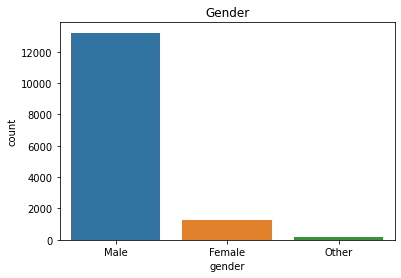

In [7]:
# plt.figure(figsize = (10, 4));
sns.countplot(x='gender', data=df_copy);

plt.title('Gender', fontsize = 12);

plt.xlabel = ('gender');
plt.ylabel = ('Количество');

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

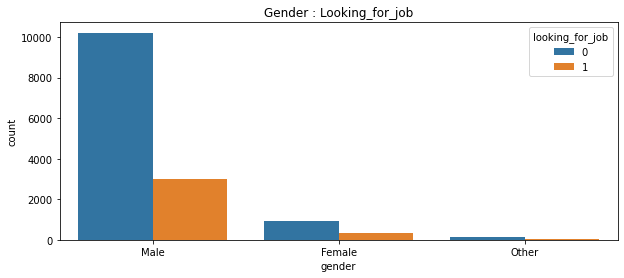

In [30]:
plt.figure(figsize = (10, 4));
sns.countplot(x='gender', data=df_copy, hue='looking_for_job');

plt.title('Gender : Looking_for_job', fontsize = 12);

plt.xlabel = ('gender');
plt.ylabel = ('Количество');

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

Мужчин подавляющее большинство. 
Количество женщин и количество тех, кто не обозначил пол, невелико.
Объединю значения Female и Other в одно значение, пропущенные данные заполню значением Other.
Заменю Other на 0, Male на 1.

In [220]:
# Проверю влияние параметра на целевую переменную.

df_copy.groupby(df_copy['gender'].isnull()).mean()

,enrollee_id,city_development_index,training_hours,looking_for_job
gender,,,,
False,17151.035222,0.839888,65.307645,0.231263
True,15979.468944,0.792970,65.559450,0.308119


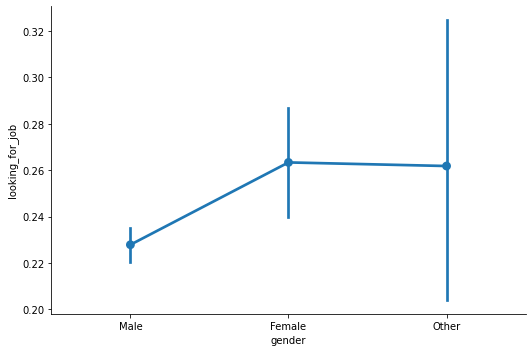

In [9]:
sns.catplot(x='gender', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

Среди тех, кто не указал свой пол, ищущих работу немного больше, чем те, у кого пол указан.


In [221]:
# Замена пропущенных значений на Other

df_copy['gender'] = df_copy['gender'].fillna('Other')

In [222]:
# Замена значения Female на Other

df_copy['gender'] = df_copy['gender'].replace('Female', 'Other')

In [223]:
# Замена Other на 0, Male на 1

df_copy['gender'] = df_copy['gender'].map({'Male':1, 'Other':0})

In [224]:
df_copy['gender'].value_counts()

1    13221
0     5937
Name: gender, dtype: int64

In [225]:
# Проверка зависимости с целевой переменной

df_copy[['gender', 'looking_for_job']].groupby(['gender'], as_index=False).mean()

,gender,looking_for_job
0,0,0.297288
1,1,0.227819


### relevent_experience

In [122]:
#df_copy['relevent_experience'] = df_input['relevent_experience']

In [226]:
df_copy['relevent_experience'].value_counts()

Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64

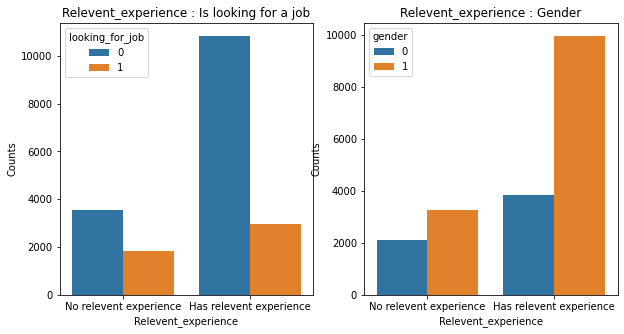

In [124]:
fg, axes = plt.subplots(1, 2, figsize=(10, 5));

sns.countplot(x='relevent_experience', data=df_copy, hue='looking_for_job', ax=axes[0]);
axes[0].set(title = 'Relevent_experience : Is looking for a job', xlabel = 'Relevent_experience', ylabel = 'Counts');

sns.countplot(x='relevent_experience', data=df_copy, hue='gender', ax=axes[1]);
axes[1].set(title = 'Relevent_experience : Gender', xlabel = 'Relevent_experience', ylabel = 'Counts');

Среди всех записавшихся на обучение имеют соответствующий опыт работы 78.5% (преимущественно мужчины - 72%, и только 21.5% из них хотят сменить работу.
Среди тех, кто собрался учиться и для кого сфера деятельности новая, 50% хотят сменить работу.
Можно сделать вывод, что у людей большая потребность в получении новых знаний.
Женщин в обоих случая почти одинаковый процент 6.3% (имеют опыт) и 6.8% (не имеют опыта) в сфере.

Заменю значения параметра:
- Has relevent experience': 1
- No relevent experience': 0

In [227]:
df_copy['relevent_experience'] = df_copy['relevent_experience'].map({'Has relevent experience': 1, 'No relevent experience': 0})

In [228]:
df_copy[['relevent_experience', 'looking_for_job']].groupby(['relevent_experience'], as_index=False).mean()

,relevent_experience,looking_for_job
0,0,0.338427
1,1,0.214690


In [229]:
df_copy['relevent_experience'] = df_copy['relevent_experience'].astype('int32')

### enrolled_university

In [230]:
df_copy['enrolled_university'].value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

In [49]:
# Проверю влияние параметра на целевую переменную.

df_copy.groupby(df_copy['enrolled_university'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,training_hours,looking_for_job
enrolled_university,,,,,,
False,16855.994993,0.829980,0.694705,0.724323,65.336991,0.247922
True,17817.031088,0.773795,0.466321,0.505181,66.821244,0.318653


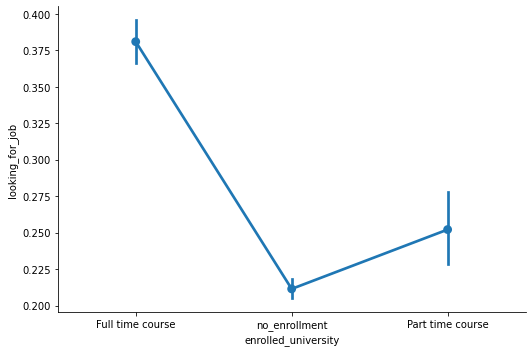

In [16]:
sns.catplot(x='enrolled_university', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

In [231]:
# Заменю пропущенные значения на Other

df_copy['enrolled_university'] = df_copy['enrolled_university'].fillna('Other')

In [232]:
df_copy['enrolled_university'].value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
Other                 386
Name: enrolled_university, dtype: int64

In [233]:
# Проверю, есть ли коррелаяиця между enrolled_university и целевой переменной

df_copy[['enrolled_university', 'looking_for_job']].groupby(['enrolled_university'], as_index=False).mean()

,enrolled_university,looking_for_job
0,Full time course,0.380889
1,Other,0.318653
2,Part time course,0.252087
3,no_enrollment,0.211406


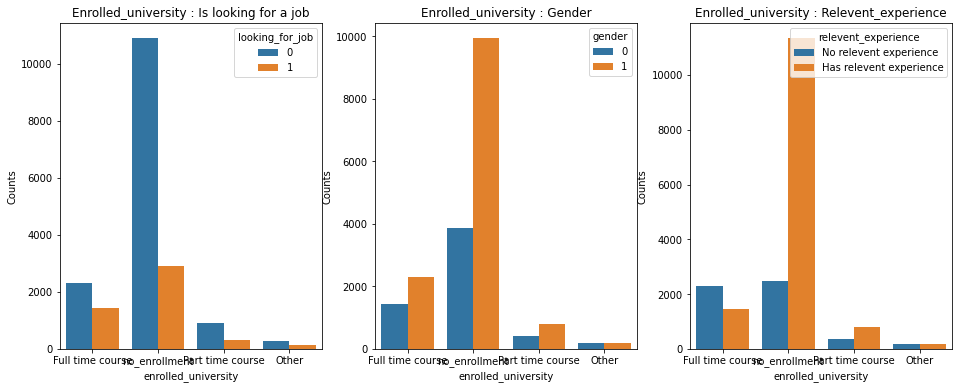

In [20]:
fg, axes = plt.subplots(1, 3, figsize=(16, 6));

sns.countplot(x='enrolled_university', data=df_copy, hue='looking_for_job', ax=axes[0]);
axes[0].set(title = 'Enrolled_university : Is looking for a job', xlabel = 'enrolled_university', ylabel = 'Counts');

sns.countplot(x='enrolled_university', data=df_copy, hue='gender', ax=axes[1]);
axes[1].set(title = 'Enrolled_university : Gender', xlabel = 'enrolled_university', ylabel = 'Counts');

sns.countplot(x='enrolled_university', data=df_copy, hue='relevent_experience', ax=axes[2]);
axes[2].set(title = 'Enrolled_university : Relevent_experience', xlabel = 'enrolled_university', ylabel = 'Counts');

Из тех, кто учился на дневном отделении, готовы сменить работу больше 50%, это, в основном, мужчины.
Все же подавляющее большинство записавшихся на обучение не имеют профильного обазования, но имеет соответствующий опыт работы.
Интересно, что среди тех, кто учился на дневном отделении больше тех, кто не имеет соответствующего опыта.

### education_level

In [234]:
df_copy['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [2033]:
df_copy['education_level'].isnull().sum()

460

In [235]:
df_copy.groupby(df_copy['education_level'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,training_hours,looking_for_job
education_level,,,,,,
False,16877.950957,0.829430,0.694138,0.726334,65.290994,0.249920
True,16769.967391,0.805207,0.526087,0.458696,68.452174,0.226087


Среди тех, у кого не указан уровень образования ищущих работу немного меньше, но разница не велика.

In [24]:
df_copy[['education_level', 'looking_for_job']].groupby(['education_level'], as_index=False).mean()

,education_level,looking_for_job
0,Graduate,0.279790
1,High School,0.195340
2,Masters,0.214400
3,Phd,0.140097
4,Primary School,0.133117


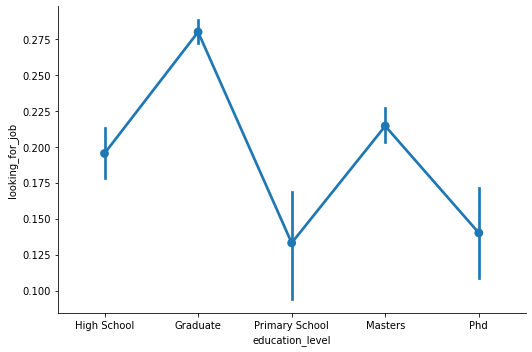

In [26]:
sns.catplot(x='education_level', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

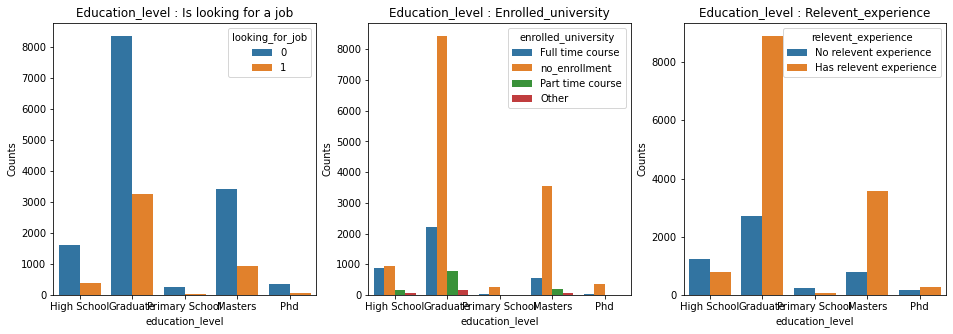

In [25]:
fg, axes = plt.subplots(1, 3, figsize=(16, 5));

sns.countplot(x='education_level', data=df_copy, hue='looking_for_job', ax=axes[0]);
axes[0].set(title = 'Education_level : Is looking for a job', xlabel = 'education_level', ylabel = 'Counts');

sns.countplot(x='education_level', data=df_copy, hue='enrolled_university', ax=axes[1]);
axes[1].set(title = 'Education_level : Enrolled_university', xlabel = 'education_level', ylabel = 'Counts');

sns.countplot(x='education_level', data=df_copy, hue='relevent_experience', ax=axes[2]);
axes[2].set(title = 'Education_level : Relevent_experience', xlabel = 'education_level', ylabel = 'Counts');

Записались на обучение преимущественно люди со степенью магистра по непрофильным специальностям, однако, имеющие практический опыт работы с этой сфере.
Кроме того, название степени Graduate и Masters - это синонимы степени Магистра. Поэтому я объединю эти значения и заменю  Masters на Graduate.

In [236]:
df_copy['education_level'] = df_copy['education_level'].replace('Masters', 'Graduate')

In [2041]:
pd.crosstab(df_copy['education_level'], df_copy['relevent_experience'])

relevent_experience,0,1
education_level,,
Graduate,3484,12475
High School,1236,781
Phd,155,259
Primary School,242,66


Интересно, что люди с уровнем образования High School и Primary School преимущественно не имеют соответствующего опыта работы, в отличие от людей со степенями Graduate и Phd.
Есть смысл объединить значения High School и Primary School в одно.

In [237]:
# Объединю High School и Primary School в одно значение School

df_copy['education_level'] = df_copy['education_level'].replace(['High School', 'Primary School'], 'School')

In [238]:
# Заменяю пропущенные значения на самое частовсречающееся Graduate

df_copy['education_level'] = df_copy['education_level'].fillna('Graduate')

In [239]:
df_copy['education_level'].value_counts()

Graduate    16419
School       2325
Phd           414
Name: education_level, dtype: int64

### major_discipline

In [38]:
#df_copy['major_discipline'] = df_input['major_discipline']

In [240]:
df_copy['major_discipline'].value_counts()

STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [40]:
df_copy['major_discipline'].isnull().sum()

2813

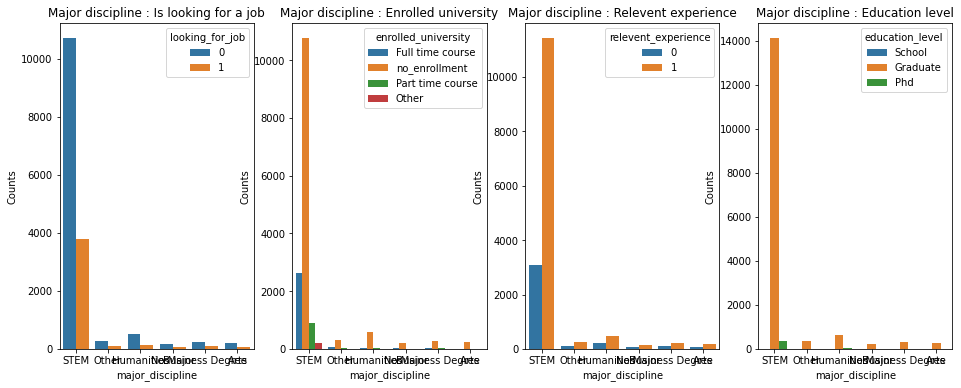

In [2049]:
fg, axes = plt.subplots(1, 4, figsize=(16, 6));

sns.countplot(x='major_discipline', data=df_copy, hue='looking_for_job', ax=axes[0]);
axes[0].set(title = 'Major discipline : Is looking for a job', xlabel = 'major_discipline', ylabel = 'Counts');

sns.countplot(x='major_discipline', data=df_copy, hue='enrolled_university', ax=axes[1]);
axes[1].set(title = 'Major discipline : Enrolled university', xlabel = 'major_discipline', ylabel = 'Counts');

sns.countplot(x='major_discipline', data=df_copy, hue='relevent_experience', ax=axes[2]);
axes[2].set(title = 'Major discipline : Relevent experience', xlabel = 'major_discipline', ylabel = 'Counts');

sns.countplot(x='major_discipline', data=df_copy, hue='education_level', ax=axes[3]);
axes[3].set(title = 'Major discipline : Education level', xlabel = 'major_discipline', ylabel = 'Counts');

Графики не показывают каких-либо интересных зависимостей.

Большинство имеют специальность STEM (аббревиатура науки (science), технологии (technology), инженерии (engineering) и математики (mathematics), степень магистра, но специализировались в смежных областях - не имют профильного образования, но имеют опыт работы в профильной сфере.

Среди технических специалистов готовы сменить работу преимущественно специалисты с опытом работы по специальности от 3 до 10 лет.
Среди молодых технических специалистов без опыта или с минимальным опытом работы в другой сфере больше половины готовы сменить работу .

In [241]:
df_copy.groupby(df_copy['major_discipline'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,training_hours,looking_for_job
major_discipline,,,,,,
False,16870.470297,0.828530,0.695626,0.778036,65.156011,0.258672
True,16903.759332,0.830693,0.658016,0.382154,66.592250,0.195165


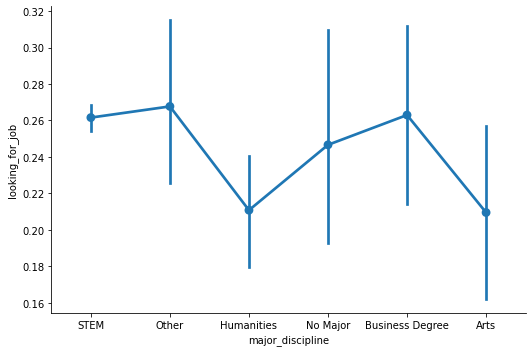

In [42]:
sns.catplot(x='major_discipline', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

In [2050]:
df_copy[['major_discipline', 'looking_for_job']].groupby(['major_discipline'], as_index=False).mean()

,major_discipline,looking_for_job
0,Arts,0.209486
1,Business Degree,0.262997
2,Humanities,0.210762
3,No Major,0.246637
4,Other,0.267717
5,STEM,0.261593


Для каждого из уровней образования средний опыт работы тех, кто готов сменить работу, ниже, чем у тех, кто ищет дополнительное образование, но не хочет менять работу. 

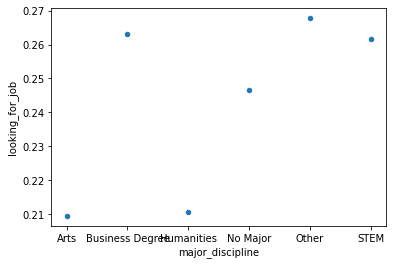

In [2051]:
df_copy[['major_discipline', 'looking_for_job']].groupby(
                                                        ['major_discipline'], 
                                                        as_index=False
                                                    ).mean().plot.scatter('major_discipline', 'looking_for_job');

На основании таблицы и графика видно, что есть небольшая зависимости между целевой переменной и основной дисциплиной.

In [242]:
# Заменю пропущенные значения на STEM

df_copy['major_discipline'] = df_copy['major_discipline'].fillna('STEM')

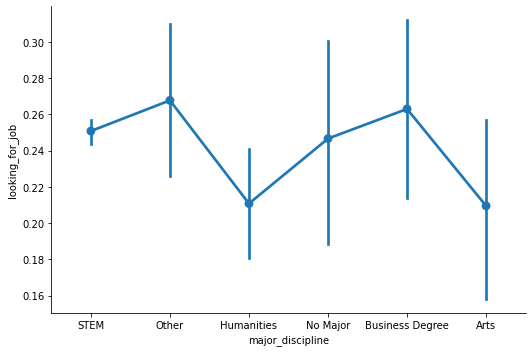

In [243]:
sns.catplot(x='major_discipline', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

In [244]:
df_copy['major_discipline'] = df_copy['major_discipline'].replace('Arts', 'Humanities')

In [49]:
#df_copy['major_discipline'] = df_copy['major_discipline'].replace('Business Degree', 'Other')

In [245]:
df_copy['major_discipline'].value_counts()

STEM               17305
Humanities           922
Other                381
Business Degree      327
No Major             223
Name: major_discipline, dtype: int64

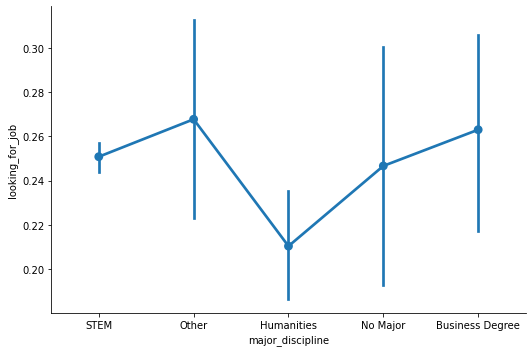

In [246]:
sns.catplot(x='major_discipline', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

### experience

In [247]:
df_copy['experience'].value_counts()

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

In [2057]:
df_copy['experience'].isnull().sum()

65

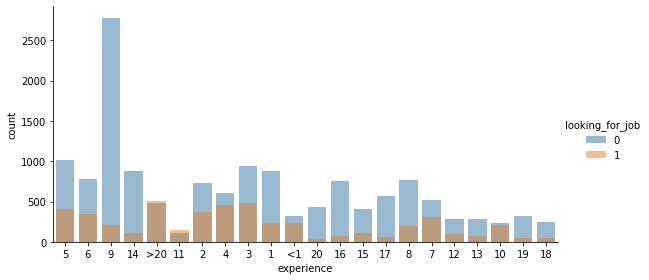

In [2058]:
grid = sns.FacetGrid(df_copy, hue='looking_for_job', size=4, aspect=2, sharey=False);
grid.map(sns.countplot, 'experience', alpha=.5);
grid.add_legend();

На графике не видно явной связи между опытом работы и целевой переменной.

In [248]:
df_copy.groupby(df_copy['experience'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,training_hours,looking_for_job
experience,,,,,,
False,16879.498298,0.829045,0.691824,0.720054,65.345257,0.248992
True,15659.246154,0.771108,0.184615,0.676923,71.723077,0.353846


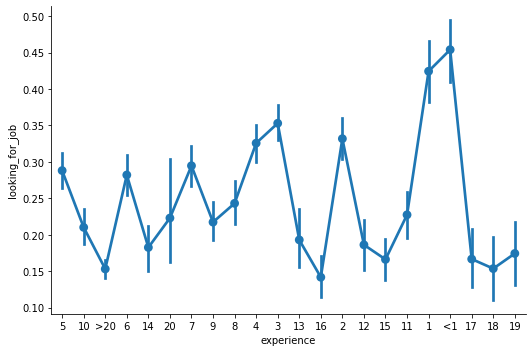

In [53]:
sns.catplot(x='experience', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

In [249]:
# Заменяю нечисловые данные на числовые

df_copy['experience'] = df_copy['experience'].replace({'<1': 0, '>20': 21})

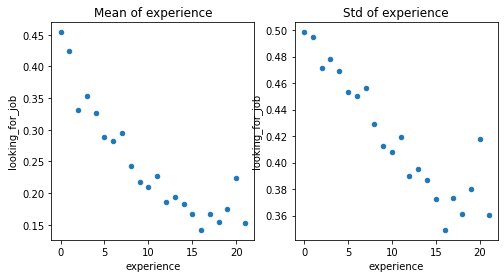

In [2060]:
# графики среднего и стандартного отклонения

fg, axes = plt.subplots(1, 2, figsize=(8, 4))

df_copy[['experience', 'looking_for_job']].groupby(['experience'], as_index=False
                                                    ).mean().plot.scatter('experience', 'looking_for_job', ax=axes[0]);
axes[0].set(title = 'Mean of experience', xlabel = 'experience', ylabel = 'looking_for_job');

df_copy[['experience', 'looking_for_job']].groupby(['experience'], as_index=False
                                                    ).std().plot.scatter('experience', 'looking_for_job', ax=axes[1]);
axes[1].set(title = 'Std of experience', xlabel = 'experience', ylabel = 'looking_for_job');

In [2061]:
# оценка коэффициента вариации experience и целевой переменной

kvar_exp = df_copy[['experience', 'looking_for_job']].groupby(['experience']).std() / df_copy[['experience', 'looking_for_job']].groupby(['experience']).mean()

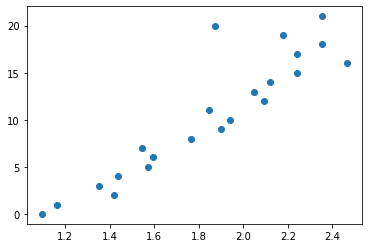

In [2062]:
plt.scatter(kvar_exp.values, kvar_exp.index);

В основном, это люди, работающие по специальности с общим рабочим стажем больше 20 лет. Из них готовы сменить работу только 15%.
Среди тех, кто готов сменить работу, больше всего людей с соотв.опытом работы 3 - 11 лет.
Наибольший процент тех, кто готов сменить работу, имеет общий рабочий стаж меньше года и 1 год (45.4% и 42%), половина из них работали по специальности.

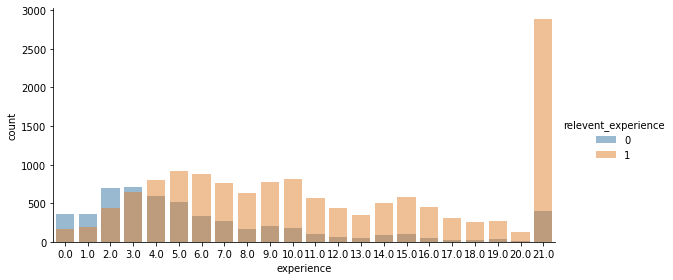

In [2064]:
grid = sns.FacetGrid(df_copy, hue='relevent_experience', size=4.0, aspect=2, sharey=False)
grid.map(sns.countplot, 'experience', alpha=.5)
grid.add_legend()

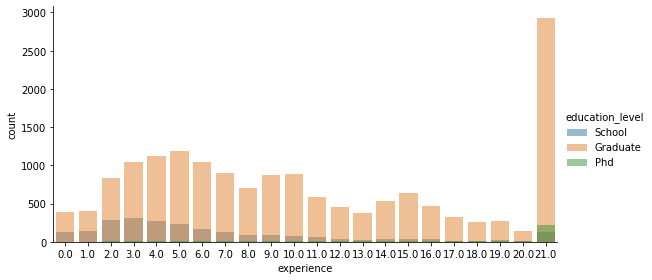

In [2065]:
grid = sns.FacetGrid(df_copy, hue='education_level', size=4, aspect=2, sharey=False)
grid.map(sns.countplot, 'experience', alpha=0.5)
grid.add_legend()

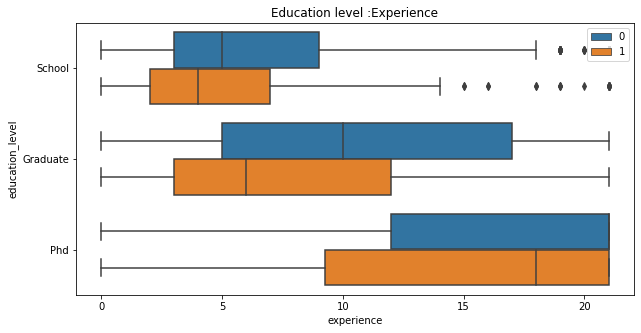

In [2066]:
plt.figure(figsize = (10, 5));
sns.boxplot(y=df_copy.education_level, x=df_copy.experience, hue=df_copy.looking_for_job);

plt.title('Education level :Experience', fontsize = 12);

plt.xlabel = ('education_level');
plt.ylabel = ('experience');
plt.legend(loc='upper right');

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

<AxesSubplot:>

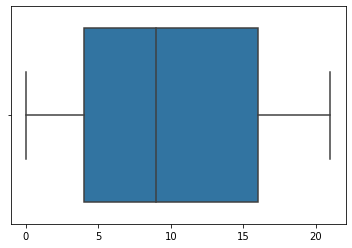

In [2067]:
sns.boxplot(df_copy.experience.values)

Из графика видно, что люди, которые готовы сменить работу, в среднем имеют общий опыт работы 9 лет, из записавшихся на учебу больше всего людей имеет опыт работы от 4 до 16 лет.

In [250]:
# Заполнюя пропущенные значения самым частовстречаемым значением 10

df_copy['experience'] = df_copy['experience'].fillna(0)

<AxesSubplot:xlabel='experience', ylabel='count'>

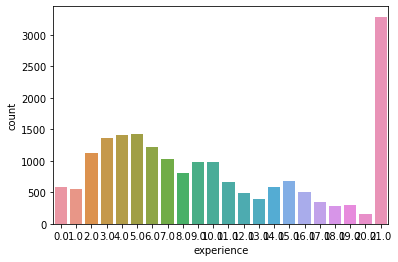

In [56]:
sns.countplot(x='experience', data=df_copy)

In [57]:
df_copy['experience'].value_counts()

21.0    3286
5.0     1430
4.0     1403
3.0     1354
6.0     1216
2.0     1127
7.0     1028
10.0     985
9.0      980
8.0      802
15.0     686
11.0     664
0.0      587
14.0     586
1.0      549
16.0     508
12.0     494
13.0     399
17.0     342
19.0     304
18.0     280
20.0     148
Name: experience, dtype: int64

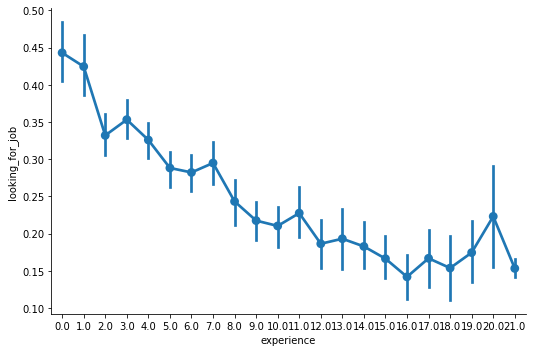

In [58]:
sns.catplot(x='experience', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

### company_size

In [251]:
df_copy['company_size'].value_counts()

50-99        3083
100-500      2571
10000+       2019
10 -- 49     1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

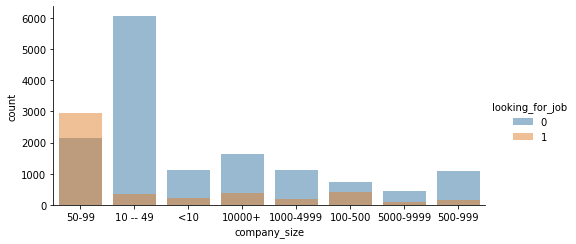

In [2227]:
grid = sns.FacetGrid(df_copy, hue='looking_for_job', size=3.5, aspect=2, sharey=False);
grid.map(sns.countplot, 'company_size', alpha=0.5);
grid.add_legend();

In [252]:
df_copy.groupby(df_copy['company_size'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,experience,training_hours,looking_for_job
company_size,,,,,,,
False,16687.406430,0.834995,0.705219,0.848033,10.741906,65.656127,0.179047
True,17293.802459,0.815162,0.656450,0.434658,8.560795,64.722971,0.405861


In [ ]:
Наличие или отсутствие размера компании является важным фактором для целевой переменной.

Добавлю колонку company_ind

In [253]:
df_copy['company_ind'] = np.where(df_copy['company_size'].isnull(), 0, 1)

In [254]:
df_copy['company_ind'].value_counts()

1    13220
0     5938
Name: company_ind, dtype: int64

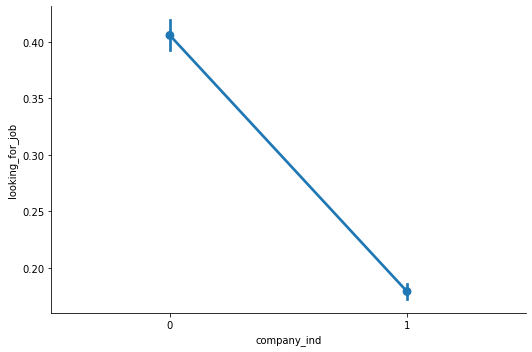

In [64]:
sns.catplot(x='company_ind', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

Есть зависимость между целевой переменной и указанием размера компании.

Пропущенных значений много. Колонку удалю. Оставлю company_ind.

In [255]:
df_copy = df_copy.drop('company_size', axis=1)

### company_type

In [256]:
df_copy['company_type'].value_counts()

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [2083]:
df_copy['company_type'].isnull().sum()

6140

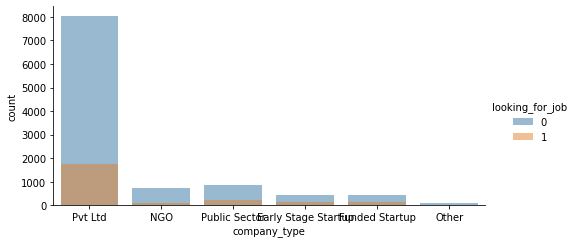

In [2084]:
grid = sns.FacetGrid(df_copy, hue='looking_for_job', size=3.5, aspect=2, sharey=False);
grid.map(sns.countplot, 'company_type', alpha=0.5);
grid.add_legend()

In [257]:
df_copy.groupby(df_copy['company_type'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,experience,training_hours,looking_for_job,company_ind
company_type,,,,,,,,
False,16552.111692,0.834931,0.709095,0.830773,10.764864,65.505684,0.183822,0.955600
True,17560.703909,0.815951,0.649837,0.484853,8.583876,65.072638,0.388274,0.127036


Среди тех, у кого указан тип компании, значительно меньше тех, кто готово менять работу, чем среди тех, у кого тип компании указан.

In [258]:
df_copy['company_type_ind'] = np.where(df_copy['company_type'].isnull(), 0, 1)

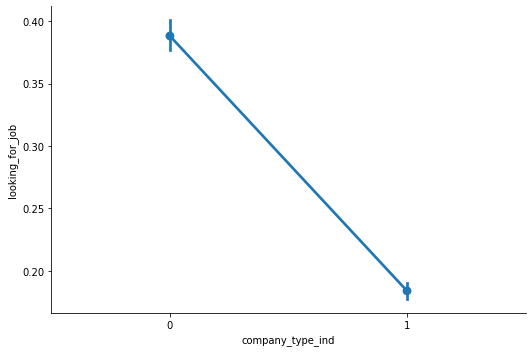

In [260]:
sns.catplot(x='company_type_ind', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

Есть сильная зависимость целевой переменной с указанием размера компании и отсутствием заполненного размера.
Оставлю характеристику company_type_ind и удалю характеристику company_type.

In [262]:
df_copy = df_copy.drop('company_type', axis=1)

### last_new_job

In [261]:
df_copy['last_new_job'].value_counts()

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64

In [92]:
df_copy['last_new_job'].describe()

count     18735
unique        6
top           1
freq       8040
Name: last_new_job, dtype: int64

In [86]:
df_copy['last_new_job'].isnull().sum()

423

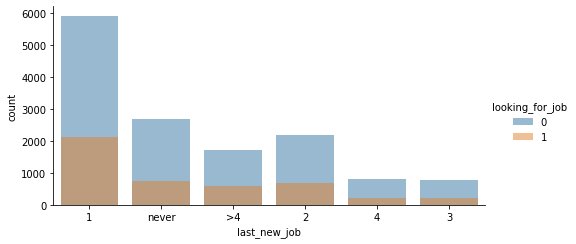

In [87]:
grid = sns.FacetGrid(df_copy, hue='looking_for_job', size=3.5, aspect=2, sharey=False);
grid.map(sns.countplot, 'last_new_job', alpha=0.5);
grid.add_legend()

In [263]:
df_copy.groupby(df_copy['last_new_job'].isnull()).mean()

,enrollee_id,city_development_index,gender,relevent_experience,experience,training_hours,looking_for_job,company_ind,company_type_ind
last_new_job,,,,,,,,,
False,16920.202402,0.830139,0.702055,0.724259,10.158100,65.493301,0.246757,0.694049,0.685135
True,14889.172577,0.771676,0.160757,0.527187,5.981087,59.768322,0.364066,0.513002,0.430260


Нет существенной разницы в количестве желающих сменить работу между кандидатами с указанным и не указанных временем последней смены работы

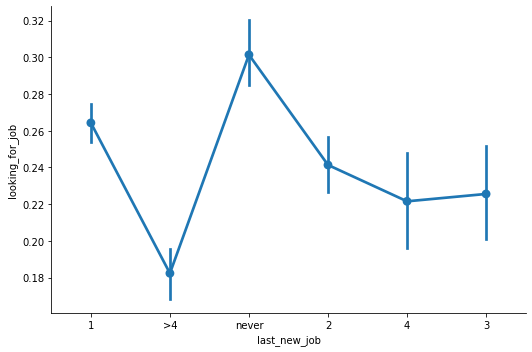

In [89]:
sns.catplot(x='last_new_job', y='looking_for_job', data=df_copy, kind='point', aspect=1.5);

Из графика видно, что количество ищущих работу больше всего среди тех, у кого это первая работа, и уменьшается по мере увеличения last_new_job

<AxesSubplot:xlabel='experience', ylabel='last_new_job'>

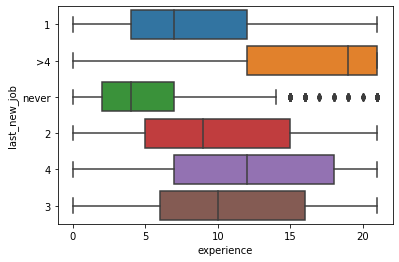

In [2099]:
sns.boxplot(y='last_new_job', x='experience', data=df_copy, orient='h')

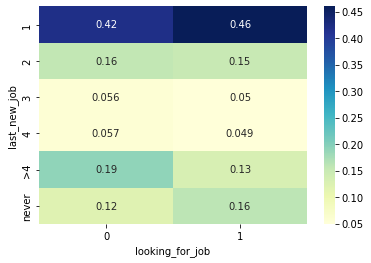

In [2101]:
sns.heatmap(pd.crosstab(df_copy['last_new_job'], df_copy['looking_for_job'], normalize = 'columns', dropna=False), cmap = "YlGnBu" ,  annot = True ,  cbar = True);

Около 50% из тех, кто записался на учебу, работает в небольших компаниях и меняли работу год назад. Причем с ростом компании уменьшается процент людей (до 39%). 
46% тех, кто менял работу год назад (для компаний любого размера), готовы менят работу.
Еще одна группа пришедших на обучение, - люди, работающие в компании среднего размера, и которые никогда не меняли работу. А также те, кто работает в средних и крупных компаниях больше 4 лет.

In [90]:
# Коэффициента вариации для last_new_job и looking_for_job. Чем меньше коэффициент вариации, тем более однородны данные.

df_copy[['looking_for_job']] \
    .groupby(df_copy['last_new_job']).std() / df_copy[['looking_for_job']].groupby(df_copy['last_new_job']).mean()

,looking_for_job
last_new_job,
1,1.668495
2,1.773116
3,1.853714
4,1.875253
>4,2.117710
never,1.522808


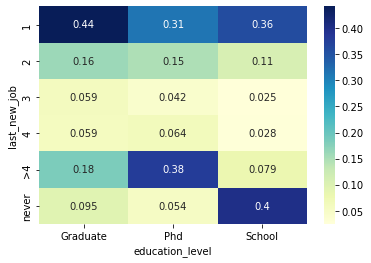

In [2103]:
sns.heatmap(pd.crosstab(df_copy['last_new_job'], df_copy['education_level'], normalize = 'columns', dropna=False), cmap = "YlGnBu" ,  annot = True ,  cbar = True);

In [264]:
df_copy['last_new_job'] = df_copy['last_new_job'].replace({'>4': 5, 'never': 0})

Колонку оставляю, пропущенные значения заменю на моду = 1

In [265]:
df_copy['last_new_job'] = df_copy['last_new_job'].fillna(1).astype('int64')

### training_hours

In [97]:
df_copy['training_hours'].value_counts()

28     329
12     292
18     291
22     282
50     279
      ... 
294      6
234      5
286      5
272      5
238      4
Name: training_hours, Length: 241, dtype: int64

In [1820]:
df_copy['training_hours'].describe()

count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

In [1644]:
df_copy.groupby('looking_for_job')['training_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
looking_for_job,,,,,,,,
0,14381.0,66.113761,60.938937,1.0,23.0,48.0,90.0,336.0
1,4777.0,63.118484,57.273662,1.0,23.0,46.0,86.0,336.0


<Figure size 864x432 with 0 Axes>

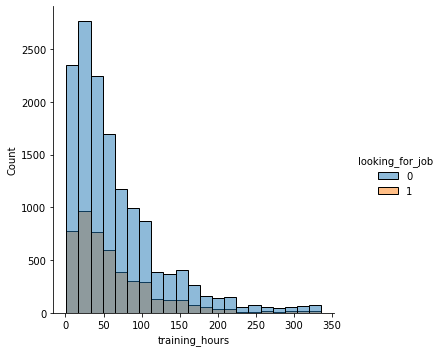

In [1645]:
plt.figure(figsize = (12, 6));
sns.displot(x='training_hours', data=df_copy, hue='looking_for_job', kind='hist', bins=21);

plt.xlabel = ('training_hours');
plt.ylabel = ('Density');

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

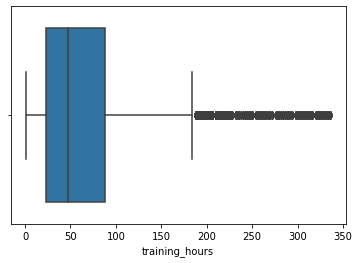

In [2108]:
sns.boxplot(x='training_hours', data=df_copy, hue='looking_for_job');

Проверю, кто прошел курсы до конца - образование, специальность, опыт работы, основная дисциплина, размер компании и тип компании 

In [266]:
df_copy.groupby('major_discipline')['training_hours'].mean()

major_discipline
Business Degree    66.189602
Humanities         64.163774
No Major           62.941704
Other              66.049869
STEM               65.431667
Name: training_hours, dtype: float64

In [267]:
df_copy[['enrolled_university', 'training_hours']].groupby(
                                                        ['enrolled_university'], 
                                                        as_index=False
                                                    ).mean()

,enrolled_university,training_hours
0,Full time course,64.532340
1,Other,66.821244
2,Part time course,67.571786
3,no_enrollment,65.362018


В среднем прошли 66.5 часов обучающей программы те, кто имел профильное образование и ни один из них не прошел программу до конца.
Не имеющие профильного образования посетили в среднем 65.2 обучающих часа. Среди этой группы есть те, кто прошел программу до конца.

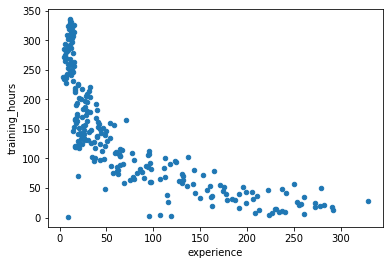

In [268]:
df_copy[['experience', 'training_hours']].groupby(
                                                        ['training_hours'], 
                                                        as_index=False
                                                    ).count().plot.scatter('experience', 'training_hours');

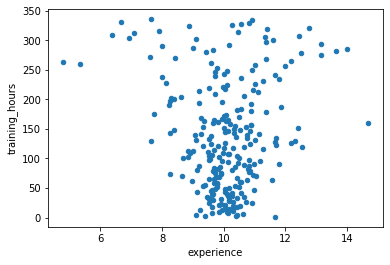

In [99]:
df_copy[['experience', 'training_hours']].groupby(
                                                        ['training_hours'], 
                                                        as_index=False
                                                    ).mean().plot.scatter('experience', 'training_hours');

Интересно, что с увеличением количества обучающих часов увеличивается и разброс по общему опыту работы.

In [269]:
df_copy[['training_hours', 'education_level']].groupby(df_copy['education_level']).mean()

,training_hours
education_level,
Graduate,65.183751
Phd,67.524155
School,66.276129


In [270]:
# Чтобы изменить экспоненциальное распределение к нормальному, прологарифимируем колонку.

df_copy['training_hours_log'] = np.log(df_copy['training_hours'])

<Figure size 864x432 with 0 Axes>

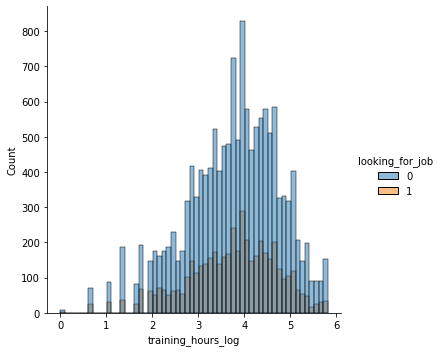

In [2119]:
plt.figure(figsize = (12, 6));
sns.displot(x='training_hours_log', data=df_copy, hue='looking_for_job', kind='hist');

plt.xlabel = ('training_hours_log');
plt.ylabel = ('Density');

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

### city

In [2120]:
df_copy['city'].isnull().sum()

0

In [2121]:
df_copy['city'].value_counts()

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64

In [271]:
df_copy['city_num'] = df_copy['city'].str.replace('city_', '', regex=False).astype('int64')

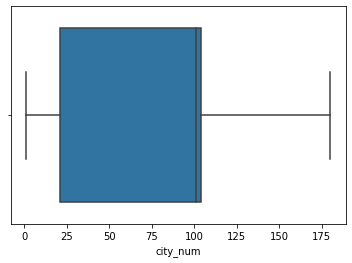

In [104]:
sns.boxplot(x='city_num', data=df_copy);

<Figure size 1080x432 with 0 Axes>

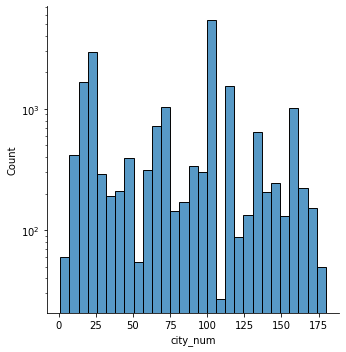

In [1655]:
plt.figure(figsize = (15, 6));
sns.displot(x='city_num', data=df_copy, kind='hist');

plt.xlabel = ('city');
plt.ylabel = ('Density');
plt.yscale('log');

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

Проверим, зависит ли пройденное время обучения от города.

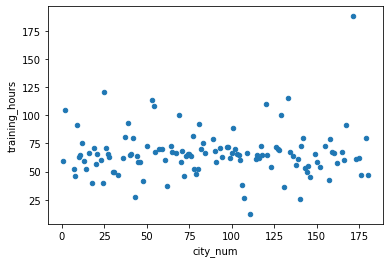

In [1656]:
df_copy[['city_num', 'training_hours']].groupby(
                                                        ['city_num'], 
                                                        as_index=False
                                                    ).mean().plot.scatter('city_num', 'training_hours');

Нет зависимости пройденного времени обучения от города.

Проверим, прослеживается ли зависимость типа компании от города для тех, кто готов менять работу и тех, кто не будет менять работу.

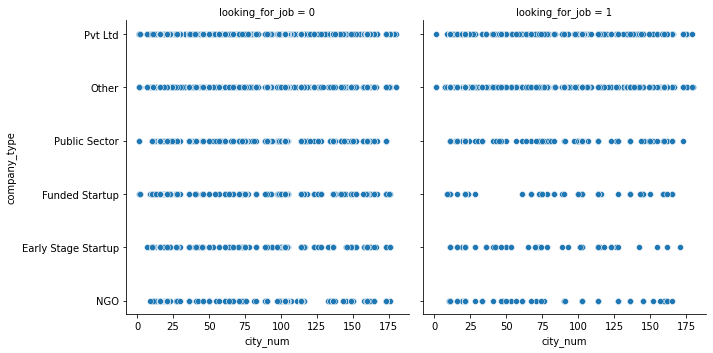

In [810]:
sns.relplot(
    data=df_copy, x='city_num', y='company_type',
    col='looking_for_job',
    kind="scatter"
);

Графики не показывают никакой интересной тенденции.
Гипотеза о зависимости типа компании, где работают те, кто ищет работу, от города не подтвердилась. 

In [105]:
df_copy[['looking_for_job']].groupby(df_copy['city_num']).mean().sort_values(by='looking_for_job', ascending=False)

,looking_for_job
city_num,
171,1.000000
139,0.800000
155,0.785714
42,0.692308
107,0.666667
...,...
111,0.000000
129,0.000000
8,0.000000


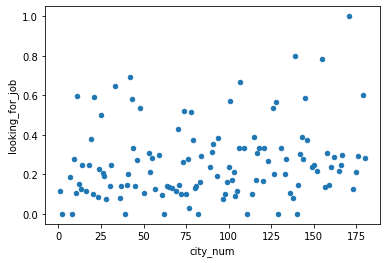

In [1658]:
df_copy[['city_num', 'looking_for_job']].groupby(
                                                        ['city_num'], 
                                                        as_index=False
                                                    ).mean().plot.scatter('city_num', 'looking_for_job');

Практически нет зависимости между переменной city и целевой переменной.
С остальными характеристиками переменная city не коррелирует.

Проверила модель с city и без этой характеристики.
Код города не оставляю для модели.

In [272]:
df_copy = df_copy.drop(['city_num', 'city'], axis=1)

### city_development_index

In [106]:
df_copy['city_development_index'].isnull().sum()

0

In [107]:
df_copy['city_development_index'].describe()

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

<Figure size 864x432 with 0 Axes>

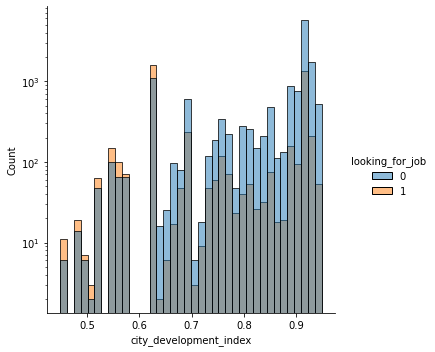

In [108]:
plt.figure(figsize = (12, 6));
sns.displot(x='city_development_index', data=df_copy, hue='looking_for_job', kind='hist');

plt.xlabel = ('city_development_index');
plt.ylabel = ('Density');
plt.yscale('log')

plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

<AxesSubplot:xlabel='city_development_index'>

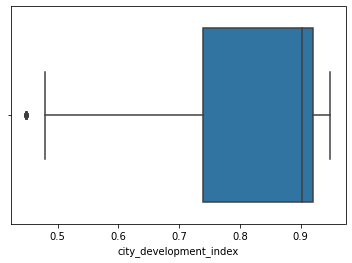

In [827]:
sns.boxplot(x='city_development_index', data=df_copy)

Разделю все индексы на 4 уровня с создам новую колонку:
- 0.800 и выше - очень высокий
- 0.699 до 0.799 - высокий
- 0.540 до 0.698 - средний
- 0.539 и ниже - низкий

In [273]:
df_copy['city_development_level'] = df_copy['city_development_index'] \
                .apply(lambda x: 'low' if x<=0.539 else 'middle' if x<=0.698 else 'high' if x<=0.799 else 'very high')

In [274]:
df_copy.groupby(by=['city_development_level'], as_index=False)[['city_development_index', 'looking_for_job']] \
                .mean().sort_values(by=['city_development_index'], ascending=False)

,city_development_level,city_development_index,looking_for_job
3,very high,0.905785,0.159566
0,high,0.758528,0.246809
2,middle,0.632757,0.507309
1,low,0.506831,0.578652


Теперь явно видна корреляция между целевой переменной и индексом уровня развития. Наблюдаем обратную зависимость - чем больше индекс развития, тем меньше количество желающих сменить работу.
Больше всего желающих - из городов с низким индексом.

In [118]:
df_copy.groupby(by=['city_development_level'], as_index=False)[['training_hours', 'experience']].mean()

,city_development_level,training_hours,experience
0,high,64.260284,8.746099
1,low,61.050562,5.887640
2,middle,65.219735,6.354500
3,very high,65.592253,11.494997


Прослеживается зависимость среднего опыта работы от уровня развития города - средний опыт растет с увеличением индекса развития.
Также среднее пройденное время обучения растет с увеличением индекса развития.

Удалю колонку city_development_index и оставлю city_development_level

In [276]:
df_copy = df_copy.drop('city_development_index', axis=1)

### Посмотрю на общую картину набора данных

In [277]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   gender                  19158 non-null  int64  
 2   relevent_experience     19158 non-null  int32  
 3   enrolled_university     19158 non-null  object 
 4   education_level         19158 non-null  object 
 5   major_discipline        19158 non-null  object 
 6   experience              19158 non-null  float64
 7   last_new_job            19158 non-null  int64  
 8   training_hours          19158 non-null  int64  
 9   looking_for_job         19158 non-null  int64  
 10  company_ind             19158 non-null  int32  
 11  company_type_ind        19158 non-null  int32  
 12  training_hours_log      19158 non-null  float64
 13  city_development_level  19158 non-null  object 
dtypes: float64(2), int32(3), int64(5), obj

In [206]:
import category_encoders as ce

Удалю лишние колонки и применю кодирование данных.

In [278]:
df_obj = df_copy[['enrolled_university', 'education_level', 'city_development_level', 'major_discipline']]

In [279]:
df_obj_code = pd.get_dummies(df_obj, columns=df_obj.columns)

In [207]:
#label_encoder1 = LabelEncoder()
#label_encoder2 = LabelEncoder()
#label_encoder6 = LabelEncoder()
#label_encoder7 = LabelEncoder()

In [208]:
#df_copy['enrolled_university_code'] = label_encoder1.fit_transform(df_copy['enrolled_university'])
#df_copy['education_level_code'] = label_encoder2.fit_transform(df_copy['education_level'])
#df_copy['city_development_level_code'] = label_encoder6.fit_transform(df_copy['city_development_level'])
#df_copy['major_discipline_code'] = label_encoder7.fit_transform(df_copy['major_discipline'])

In [338]:
df_last = df_copy.drop(['enrollee_id', 'enrolled_university', 'education_level', 'city_development_level', 'major_discipline', 'training_hours'], axis=1)

In [339]:
df_last = pd.concat([df_last, df_obj_code], axis=1)

In [340]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   gender                                19158 non-null  int64  
 1   relevent_experience                   19158 non-null  int32  
 2   experience                            19158 non-null  float64
 3   last_new_job                          19158 non-null  int64  
 4   looking_for_job                       19158 non-null  int64  
 5   company_ind                           19158 non-null  int32  
 6   company_type_ind                      19158 non-null  int32  
 7   training_hours_log                    19158 non-null  float64
 8   enrolled_university_Full time course  19158 non-null  uint8  
 9   enrolled_university_Other             19158 non-null  uint8  
 10  enrolled_university_Part time course  19158 non-null  uint8  
 11  enrolled_univer

Проверю корреляцию характеристик с целевой переменной.

In [341]:
df_corr = df_last.corr(method='spearman')['looking_for_job'][:-1]
corr = df_last.corr()

In [342]:
feature_list = df_corr[abs(df_corr) > 0.1].sort_values(ascending=False)
print('{} признаков с сильной корреляцией с целевой переменной:\n{}'.format(len(feature_list), feature_list))

9 признаков с сильной корреляцией с целевой переменной:
looking_for_job                         1.000000
city_development_level_middle           0.324514
enrolled_university_Full time course    0.150171
relevent_experience                    -0.128430
enrolled_university_no_enrollment      -0.141054
experience                             -0.183926
company_type_ind                       -0.220533
company_ind                            -0.242456
city_development_level_very high       -0.308586
Name: looking_for_job, dtype: float64


<AxesSubplot:>

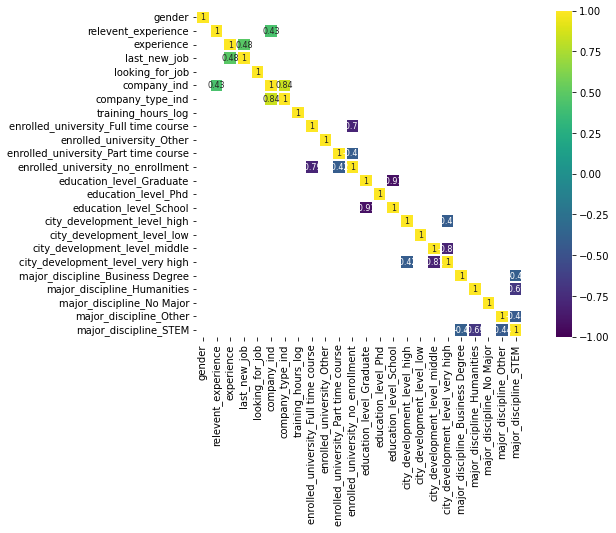

In [343]:
plt.figure(figsize = (12, 6))
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)],
           cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
           annot=True, annot_kws={'size': 8}, square=True)

### Modeling and Prediction

In [344]:
X = df_last.drop('looking_for_job', axis=1)
y = df_last['looking_for_job']

Есть существенный дисбаланс классов, поэтому применим SMOTE оверсемплинг.

In [345]:
smote = SMOTE(random_state=42)
X_s, y_s = smote.fit_resample(X, y)

In [346]:
y_s.value_counts()

0    14381
1    14381
Name: looking_for_job, dtype: int64

In [178]:
#scaler_x = RobustScaler()
#X_sc = scaler_x.fit_transform(X_s)

### Train Test Split

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, random_state=42)

### Построение моделей

### Logistic Regression

In [348]:
lr_clf = LogisticRegression()

In [349]:
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [350]:
y_train_pred = lr_clf.predict(X_train)
y_test_pred = lr_clf.predict(X_test)
y_score = lr_clf.predict_proba(X_test)[:, 1]

In [351]:
print('score на трейне', lr_clf.score(X_train, y_train))
print('score на тесте', lr_clf.score(X_test, y_test))

score на трейне 0.7657966714570488
score на тесте 0.7734668335419274


In [352]:
feature_names = X.columns

In [353]:
import math

In [354]:
w = lr_clf.coef_[0]
w

array([-0.20705732, -0.25130793, -0.02312817,  0.05148438, -1.05523409,
       -0.42793387, -0.0182322 , -4.49683505, -5.68776382, -4.93650997,
       -4.62983   , -2.38607057, -2.78326428, -3.7250712 , -4.45791674,
       -3.32171617, -2.77395633, -4.56558933, -2.96723371, -2.89336487,
       -3.24779449, -3.35084774, -2.62980732])

In [355]:
feature_import = pd.DataFrame(feature_names, columns=['feature'])

In [356]:
feature_import['Importance'] = pow(math.e, w)

In [357]:
feature_import = feature_import.sort_values(by=['Importance'], ascending=False)

In [358]:
feature_import

,feature,Importance
3,last_new_job,1.052833
6,training_hours_log,0.981933
2,experience,0.977137
0,gender,0.812973
1,relevent_experience,0.777783
5,company_type_ind,0.651855
4,company_ind,0.348111
11,education_level_Graduate,0.091990
22,major_discipline_STEM,0.072092
16,city_development_level_middle,0.062415


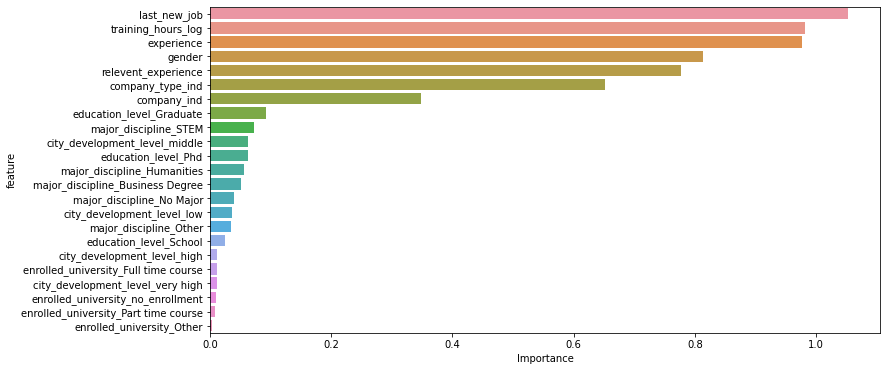

In [359]:
plt.figure(figsize = (12, 6));
sns.barplot(y='feature', x='Importance', data=feature_import);

####  M1 - XGBoost

In [360]:
xgb_clf = xgb.XGBClassifier(random_state=42)

In [361]:
xgb_clf.fit(X_train, y_train)

[14:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [362]:
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
y_score = xgb_clf.predict_proba(X_test)[:, 1]

In [363]:
print('score на трейне', xgb_clf.score(X_train, y_train))
print('score на тесте', xgb_clf.score(X_test, y_test))

score на трейне 0.8675536600064901
score на тесте 0.8265887915449868


In [364]:
print('confusion_matrix:')

print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

confusion_matrix:
[[9317 1495]
 [1362 9397]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3569
           1       0.83      0.83      0.83      3622

    accuracy                           0.83      7191
   macro avg       0.83      0.83      0.83      7191
weighted avg       0.83      0.83      0.83      7191



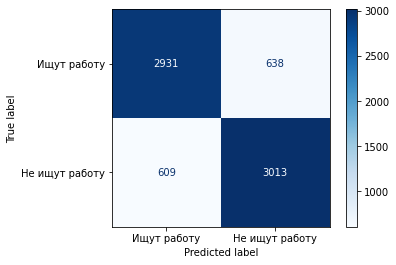

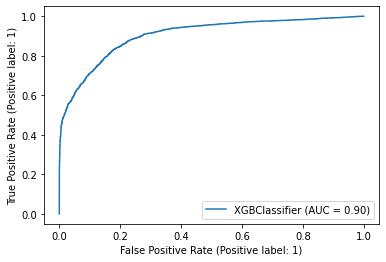

In [365]:
disp = plot_confusion_matrix(
    xgb_clf, X_test, y_test,
    cmap = 'Blues', values_format='d',
    display_labels = ['Ищут работу', 'Не ищут работу']
)

disp = plot_roc_curve(xgb_clf, X_test, y_test)

In [376]:
feature_imp_xgb = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp_xgb

city_development_level_very high        0.210480
company_ind                             0.114780
city_development_level_high             0.102490
education_level_School                  0.065517
major_discipline_No Major               0.064365
education_level_Phd                     0.061411
enrolled_university_Other               0.059783
major_discipline_Other                  0.035878
major_discipline_Business Degree        0.035056
enrolled_university_Part time course    0.034697
city_development_level_low              0.034137
major_discipline_Humanities             0.025577
training_hours_log                      0.019734
enrolled_university_Full time course    0.016988
education_level_Graduate                0.016734
city_development_level_middle           0.016677
company_type_ind                        0.015965
experience                              0.013729
relevent_experience                     0.013203
major_discipline_STEM                   0.012991
enrolled_university_

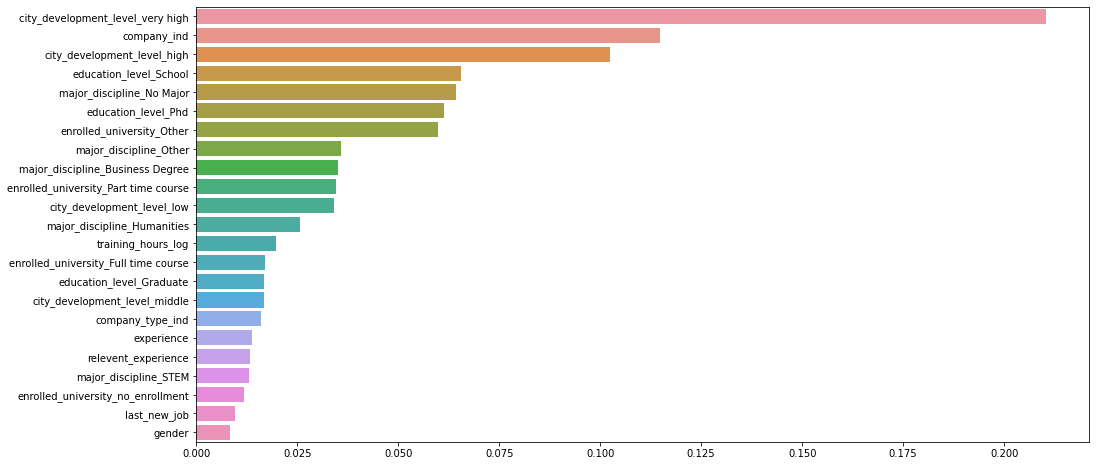

In [367]:
plt.figure(figsize = (16, 8));
sns.barplot(x=feature_imp_xgb, y=feature_imp_xgb.index);

График позволяет визуально оценить портрет будущего соискателя.

#### RandomForest

In [368]:
RF_clf = RandomForestClassifier(min_samples_split=100, n_estimators = 500, random_state=42)
                                
RF_clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=100, n_estimators=500, random_state=42)

In [369]:
y_train_pred = RF_clf.predict(X_train)
y_test_pred = RF_clf.predict(X_test)
y_score = RF_clf.predict_proba(X_test)[:, 1]

In [370]:
print('score на трейне', RF_clf.score(X_train, y_train))
print('score на тесте', RF_clf.score(X_test, y_test))

score на трейне 0.7813731398637059
score на тесте 0.7781949659296342


In [371]:
print('confusion_matrix:')
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

confusion_matrix:
[[8170 2642]
 [2074 8685]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      3569
           1       0.77      0.80      0.78      3622

    accuracy                           0.78      7191
   macro avg       0.78      0.78      0.78      7191
weighted avg       0.78      0.78      0.78      7191



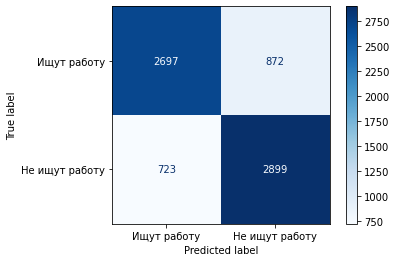

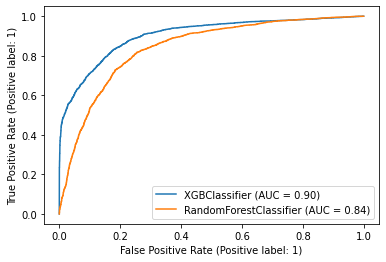

In [372]:
disp = plot_confusion_matrix(
    RF_clf, X_test, y_test,
    cmap = 'Blues', values_format='d',
    display_labels = ['Ищут работу', 'Не ищут работу']
)

disp = plot_roc_curve(xgb_clf, X_test, y_test)
plot_roc_curve(RF_clf, X_test, y_test, ax=disp.ax_)

In [373]:
feature_imp = pd.Series(RF_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

In [374]:
feature_imp

city_development_level_very high        0.176147
city_development_level_middle           0.171177
company_ind                             0.132915
company_type_ind                        0.096987
experience                              0.093541
training_hours_log                      0.076820
city_development_level_high             0.034917
last_new_job                            0.033727
relevent_experience                     0.030663
education_level_School                  0.028152
education_level_Graduate                0.024217
enrolled_university_no_enrollment       0.023690
enrolled_university_Full time course    0.014734
gender                                  0.011803
enrolled_university_Part time course    0.009579
enrolled_university_Other               0.008657
major_discipline_STEM                   0.008076
education_level_Phd                     0.005761
major_discipline_Humanities             0.005741
major_discipline_Other                  0.004045
major_discipline_Bus

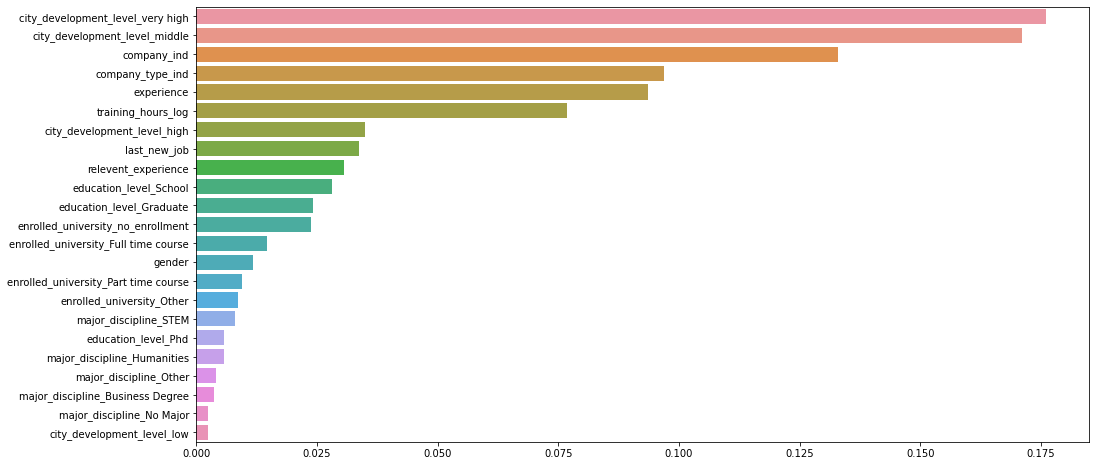

In [375]:
plt.figure(figsize = (16, 8));
sns.barplot(x=feature_imp, y=feature_imp.index);

**Выводы**:
    Модель **XGBoost** показала самый лучший результат.
    Accuracy - 83% и Roc Auc - 90%
    
    
На основании модели сформировался такой профиль соискателей:
- Люди из городов с очень высоким и высоким уровнем развития,
- Которые указали размер компании, в которой работают.
- у которых есть или школьное образование, или доктор философии. 
- без основной специальности, не указана основная специальность или есть бизнес-образование,
- у которых не указан оконченный учебный курс или есть заочное образование.
- Пройденное время обучения может быть дополнительным критерием отбора

Общий опыт работы, наличие опыта работы по специальности обучающего курса, время работы на одном месте и пол практически не влияют на отбор кандидата.

Возможные пути улучшения точности модели:

- Для модели XGBoost оптимизировать гиперпараметры.
- Добавить новые характеристики с бОльшей корреляцией с целевой переменной.
- Улучшить качество входных данных, чтобы минимизировать пропущенные значения.
- Также, дополнить новыми признаками.

В наборе данных не представлены характеристики, которые могут помочь более точной классифицикации. Например, возраст, удовлетворенность существующей работой, позиция работника (менеджер, руководитель среднего звена и т.д.). 

В зависимости от того, какая задача поставлена HR-у руководством компании, можно "на входе" ограничить некоторые группы соискателей или более точно сформулировать критерии отбора заявок на обучение.
Дальнейшая работа по повышению точности классификации также зависит от требований бизнеса.